In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score,precision_recall_fscore_support, classification_report)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

np.random.seed(42)

In [ ]:
# Dataset Generation (2 features, 5 classes)
N_SAMPLES = 5000        # total samples (adjust as needed)
N_CLASSES = 5
N_FEATURES = 2          # matches inputLayerNeurons = 2

X, y = make_blobs(n_samples=N_SAMPLES,centers=N_CLASSES,n_features=N_FEATURES,cluster_std=2.0,random_state=42)
#i have set cluster_std=2.0 to get more realistice RUC= 0.98,0.95 if cluster_std=1.2 then RUC Become 1
print(X.shape)
print(y.shape)

(5000, 2)
(5000,)


In [34]:
# Shuffle and split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# Applying  StandardScaler on train and test feature
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Applying One-hot encoding on class or target 
def one_hot(labels, n_classes):
    out = np.zeros((labels.shape[0], n_classes))
    out[np.arange(labels.shape[0]), labels] = 1
    return out

Y_train_oh = one_hot(y_train, N_CLASSES)
Y_test_oh  = one_hot(y_test, N_CLASSES)

In [35]:
# Neural Network Implementation

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01, seed=42):
        #hidden_dims: list or tuple of three integers [64, 32, 16]
        np.random.seed(seed)
        self.lr = lr

        # Architecture
        self.input_dim = input_dim
        self.hidden_dims = list(hidden_dims)
        self.output_dim = output_dim

        # Initialize weights (He initialization function for ReLU)
        def he_init(fan_in, fan_out):
            return np.random.randn(fan_in, fan_out) * np.sqrt(2. / fan_in) #* np.sqrt(2. / fan_in) used to avoid vanishing gradient problem

        self.W1 = he_init(self.input_dim, self.hidden_dims[0]) #input dim= 2 hidden_dim[0]=62 1st hidden layer's neuron amount
        self.b1 = np.zeros((1, self.hidden_dims[0])) #bias as 0

        self.W2 = he_init(self.hidden_dims[0], self.hidden_dims[1]) #for hidden 1 and 2 layer
        self.b2 = np.zeros((1, self.hidden_dims[1]))

        self.W3 = he_init(self.hidden_dims[1], self.hidden_dims[2])#for hidden 2 and 3 layer
        self.b3 = np.zeros((1, self.hidden_dims[2]))

        self.W4 = np.random.randn(self.hidden_dims[2], self.output_dim) * 0.01 #for hidden  and output layer
        self.b4 = np.zeros((1, self.output_dim))

    # Activation functions
    def relu(self, x):
        return np.maximum(0, x)
    def relu_derivative(self, x): # For back propagation
        return (x > 0).astype(float)

    def softmax(self, x):
        # stable softmax
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  #In stble softmax we deduct max (z)
        return exps / np.sum(exps, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X):
        # Layer 1
        self.Z1 = X.dot(self.W1) + self.b1    # (N, hidden1) Calculating Z= x*W +b
        self.A1 = self.relu(self.Z1) #Applying Activation Function

        # Layer 2
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = self.relu(self.Z2)

        # Layer 3
        self.Z3 = self.A2.dot(self.W3) + self.b3
        self.A3 = self.relu(self.Z3)

        # Output Layer
        self.Z4 = self.A3.dot(self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)      # probabilities Of output Layer

        return self.A4

    # Cross-entropy loss (average) The code calculates the average loss across all samples in the batch.
    def compute_loss(self, Y_true, Y_pred):
        # Y_true is one-hot, Y_pred are probabilities
        m = Y_true.shape[0]
        # Adding small epsilon to avoid log(0)
        eps = 1e-12
        loss = -np.sum(Y_true * np.log(Y_pred + eps)) / m
        return loss

    # Backward pass (backpropagation)
    def backward(self, X, Y_true, Y_pred):
        m = X.shape[0]

        # dLoss/dZ4 where Z4 is pre-softmax logits
        dZ4 = (Y_pred - Y_true) / m  # shape (m, output_dim)

        # Gradients for W4, b4 dW4=Gradient Descent Weight 4 and db4= Gradient Descent Bias 4
        dW4 = self.A3.T.dot(dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # Backprop into layer 3
        dA3 = dZ4.dot(self.W4.T)
        dZ3 = dA3 * self.relu_derivative(self.Z3)
        dW3 = self.A2.T.dot(dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backprop into layer 2
        dA2 = dZ3.dot(self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = self.A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backprop into layer 1
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update weights (gradient descent)
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    # Train for one epoch (optionally with mini-batches)
    def train_epoch(self, X, Y, batch_size=None):
        n = X.shape[0]
        if batch_size is None or batch_size >= n:
            # full-batch
            probs = self.forward(X)
            loss = self.compute_loss(Y, probs)
            self.backward(X, Y, probs)
            return loss
        else:
            # mini-batch SGD
            permutation = np.random.permutation(n)
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]
            losses = []
            for i in range(0, n, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                probs = self.forward(X_batch)
                loss_b = self.compute_loss(Y_batch, probs)
                losses.append(loss_b)
                self.backward(X_batch, Y_batch, probs)
            return np.mean(losses)

    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

Epoch   1 | Loss: 0.7166 | Train Acc: 0.8578
Epoch  20 | Loss: 0.2766 | Train Acc: 0.8745
Epoch  40 | Loss: 0.2756 | Train Acc: 0.8870
Epoch  60 | Loss: 0.2738 | Train Acc: 0.8775
Epoch  80 | Loss: 0.2717 | Train Acc: 0.8800
Epoch 100 | Loss: 0.2721 | Train Acc: 0.8840
Epoch 120 | Loss: 0.2735 | Train Acc: 0.8770
Epoch 140 | Loss: 0.2714 | Train Acc: 0.8815
Epoch 160 | Loss: 0.2708 | Train Acc: 0.8758
Epoch 180 | Loss: 0.2698 | Train Acc: 0.8828
Epoch 200 | Loss: 0.2716 | Train Acc: 0.8832

Test Accuracy: 0.889
Per-class Precision: [0.877 0.892 1.    0.979 0.731]
Per-class Recall   : [0.925 0.74  1.    0.925 0.855]
Per-class F1       : [0.9   0.809 1.    0.951 0.788]

Macro Precision: 0.896 Macro Recall: 0.889 Macro F1: 0.89

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       200
           1       0.89      0.74      0.81       200
           2       1.00      1.00      1.00       200
           3       0.98

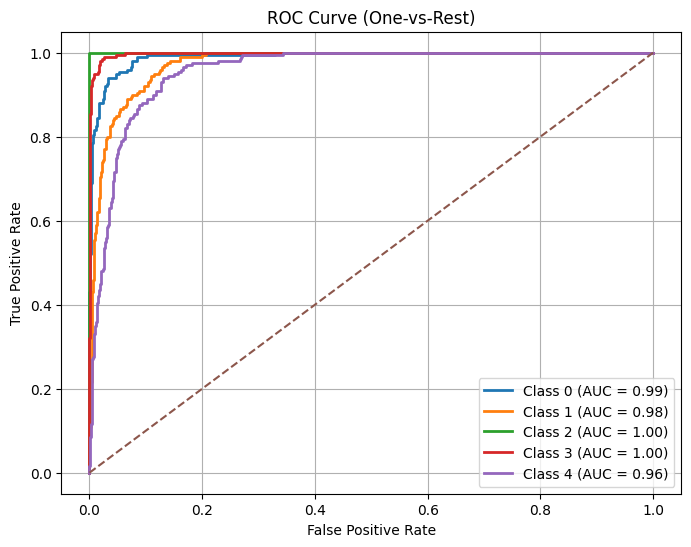

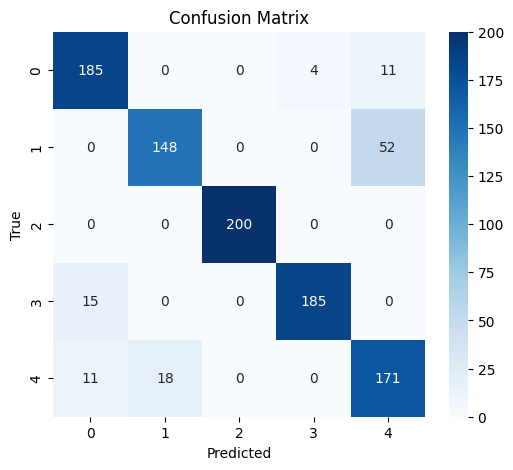

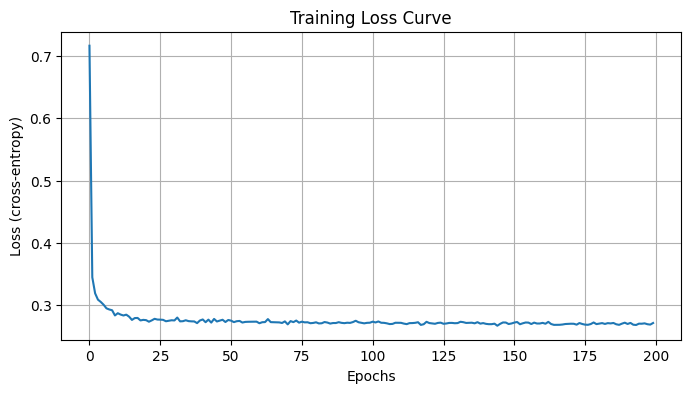

In [36]:
# Create and Train the Network

# Network hyperparameters
hidden_dims = [64, 32, 16]   # three hidden layers
learning_rate = 0.05
batch_size = 64        # mini-batch
n_epochs = 200

nn = NeuralNetwork(input_dim=N_FEATURES,hidden_dims=hidden_dims,output_dim=N_CLASSES,lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(1, n_epochs + 1):
    loss = nn.train_epoch(X_train, Y_train_oh, batch_size=batch_size)
    train_losses.append(loss)
    if epoch % 20 == 0 or epoch == 1:
        preds_train = nn.predict(X_train)
        acc_train = accuracy_score(y_train, preds_train)
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Train Acc: {acc_train:.4f}")


# Evaluate on Test Set

probs_test = nn.predict_proba(X_test)
y_pred_test = np.argmax(probs_test, axis=1)

acc_test = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average=None, labels=range(N_CLASSES))
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro', labels=range(N_CLASSES))

print("\nTest Accuracy:", acc_test)
print("Per-class Precision:", np.round(prec, 3))
print("Per-class Recall   :", np.round(rec, 3))
print("Per-class F1       :", np.round(f1, 3))
print("\nMacro Precision:", round(prec_macro,3), "Macro Recall:", round(rec_macro,3), "Macro F1:", round(f1_macro,3))

# Classification report (nice formatting)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))

# Roc curve
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=range(N_CLASSES))   # shape: (n_samples, 5)

# Predictions: probs_test already computed as softmax outputs
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for c in range(N_CLASSES):
    fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], probs_test[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], lw=2,
             label=f"Class {c} (AUC = {roc_auc[c]:.2f})")

# Random guess line
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(N_CLASSES), yticklabels=range(N_CLASSES))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Loss curve
plt.figure(figsize=(8,4))
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss (cross-entropy)')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()



# Documentation

The original binary-class neural network was modified to support five-class classification by expanding the output layer to five neurons and replacing the sigmoid activation with a softmax function, allowing probability distribution across all classes. The loss function was updated to categorical cross-entropy, and backpropagation was adapted to compute gradients of the multi-class softmax output.

Three hidden layers were introduced with ReLU activation, improving feature extraction and addressing vanishing gradients. Weight initialization was upgraded to He initialization for stable training. Additionally, one-hot encoding was applied to labels to match the multi-class output structure.

Key implementation challenges included ensuring correct matrix dimensions during backpropagation and maintaining numerical stability in softmax, both resolved through careful reshaping and the use of stabilized softmax computations.

# Conclution
The multi-class neural network was successfully extended to classify five classes using three hidden layers with softmax output and cross-entropy loss. The model achieved strong average accuracy of 0.889 and Precision: 0.896 ,Recall: 0.889 andF1: 0.89, confirming that the architecture and training process effectively captured the class boundaries.
Key challenges included ensuring correct one-hot encoding, stabilizing softmax computations, and adapting backpropagation for multi-class gradients. Addressing these improved both numerical stability and training performance.
Future enhancements could include adding regularization, using advanced optimizers like Adam, or testing deeper architectures to further improve generalization on more complex datasets.
